In [32]:
from keras.preprocessing.image import load_img, array_to_img
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import optimizers
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
import cv2
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential, Model, load_model
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 5)
import warnings
warnings.filterwarnings('ignore')
from utils import get_train_test_valid_split
# from google.colab import files

# Exploratory Data Analysis

In [35]:
data = np.load(r'..data/fashion_mnist_dataset_train.npy', allow_pickle=True).item()
data

{'features': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0

In [36]:
data['features'][0].shape

(28, 28)

In [37]:
np.max(data['features'])

1.0

The images are already normalized between 0 and 1 and are grayscale i.e single-channel.

In [38]:
data['target']

array([5., 2., 1., ..., 3., 1., 4.])

In [39]:
set(data['target'])

{1.0, 2.0, 3.0, 4.0, 5.0}

In [40]:
# numpy index starts with 0 just like python so need to transform it to be able to use to_categorical()
data['target'] = data['target'] - 1

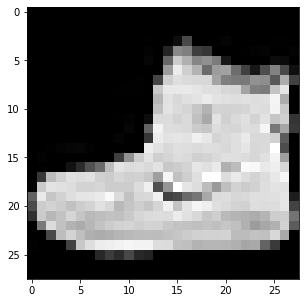

In [112]:
plt.imshow(data['features'][0], cmap='gray')

In [42]:
pixel_count = data['features'][0].shape[0] * data['features'][0].shape[1]

In [43]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_test_valid_split(data['features'], data['target'], valid=0.2, test=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(36000, 28, 28)
(36000,)
(12000, 28, 28)
(12000,)
(12000, 28, 28)
(12000,)


In [44]:
# flatten image and normalize between 0 and 1

def flatten_image_set(image_set, pixel_count):
    return np.reshape(image_set, (len(image_set), pixel_count))

X_train_flat = flatten_image_set(X_train, pixel_count)
X_valid_flat = flatten_image_set(X_valid, pixel_count)
X_test_flat  = flatten_image_set(X_test, pixel_count)

X_train_flat.shape

(36000, 784)

In [45]:
# one-hot encode target
class_count = len(set(data['target'])) 

y_train = to_categorical(y_train, class_count)
y_valid = to_categorical(y_valid, class_count)
y_test = to_categorical(y_test, class_count)

y_train

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [46]:
y_test.shape

(12000, 5)

> # CM4, CM5 and CM6 are done in parallel for 3 different models. All sections have been given the appropriate headings.

# CM4 for FCN

Fully-Connected Neural Network

As a baseline model and in order to be able to appreciate CNN better for image classification problems, I will first use an simple fully-connected (aka dense), sequential neural network. A sequential model is a plain stack of layers where each layer has exactly one input tensor and one output tensor.

Optimizer: Adam

Activation Functions: ReLU for internal and Softmax for output layer

Regularization Method: Early Stopping and Dropout layers.

Number of parameters: 667,141

Network Architecture: A fully-connected (dense), sequential model

![title](../images/dense.jpg)

Credits: https://www.linkedin.com/learning/neural-networks-and-convolutional-neural-networks-essential-training/

# CM5 for FCN

## Implementation for FCN

In [47]:
dense_model = Sequential()
dense_model.add(Dense(512, activation='relu', input_shape=(len(X_train_flat[0]),)))
dense_model.add(Dropout(0))
# input_shape's first argument is the number of dimensions of a single training sample. Sometimes, though, you just have one dimension – which is the case with one-dimensional / flattened arrays, for example. In this case, you can also simply use input_dim = number of dimensions of a training sample i.e no tuple

dense_model.add(Dense(512, activation='relu'))
dense_model.add(Dropout(0))
dense_model.add(Dense(class_count, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.01)
dense_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 

# early stopping to avoid overfitting
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)
mc = ModelCheckpoint('../model/dense_model/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# remember .fit() continues training from where we left off the last time
history_dense_model = dense_model.fit(X_train_flat, y_train,
                                        epochs=10,
                                        validation_data=(X_valid_flat, y_valid),
                                        callbacks=[es, mc])

Epoch 1/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.0600 - accuracy: 0.6529 - val_loss: 0.6178 - val_accuracy: 0.7648

Epoch 00001: val_accuracy improved from -inf to 0.76483, saving model to model/dense_model/best_model.h5
Epoch 2/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6139 - accuracy: 0.7499 - val_loss: 0.6270 - val_accuracy: 0.7398

Epoch 00002: val_accuracy did not improve from 0.76483
Epoch 3/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5730 - accuracy: 0.7667 - val_loss: 0.6153 - val_accuracy: 0.7562

Epoch 00003: val_accuracy did not improve from 0.76483
Epoch 4/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5564 - accuracy: 0.7715 - val_loss: 0.5476 - val_accuracy: 0.7752

Epoch 00004: val_accuracy improved from 0.76483 to 0.77517, saving model to model/dense_model/best_model.h5
Epoch 5/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5478 - accuracy: 0.

In [48]:
dense_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2565      
Total params: 667,141
Trainable params: 667,141
Non-trainable params: 0
_________________________________________________________________


In [49]:
# # save model configuration

# model_config = dense_model.to_json()

# with open("../model/config/dense_model.json", "w") as json_file:
#     json_file.write(model_config)

# CM6 for FCN

Results Analysis for FCN

In [50]:
# evaluate the model
train_loss, train_acc = dense_model.evaluate(X_train_flat, y_train, verbose=0)
test_loss, test_acc = dense_model.evaluate(X_test_flat, y_test, verbose=0)

print("Accuracy:")
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print("Loss:")
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

Accuracy:
Train: 0.797, Test: 0.782
Loss:
Train: 0.499, Test: 0.545


Text(0.5, 1.0, 'Training History')

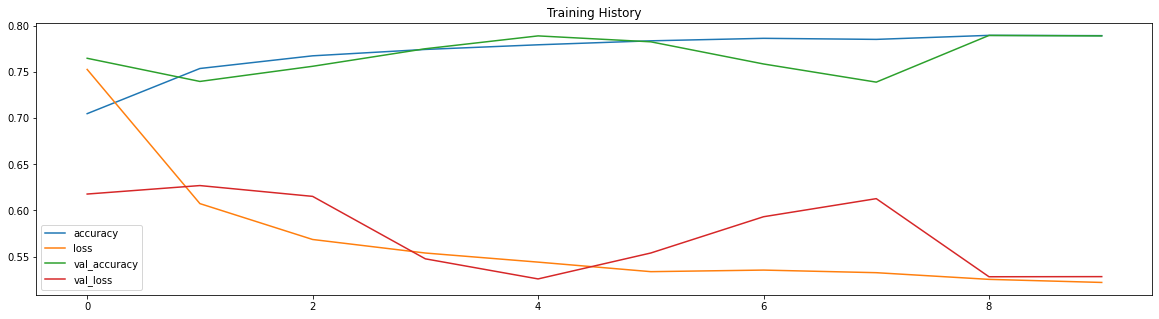

In [113]:
plt.plot(history_dense_model.history['accuracy'])
plt.plot(history_dense_model.history['loss'])
plt.plot(history_dense_model.history['val_accuracy'])
plt.plot(history_dense_model.history['val_loss'])
plt.legend(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
plt.title("Training History")

Text(0, 0.5, 'Loss')

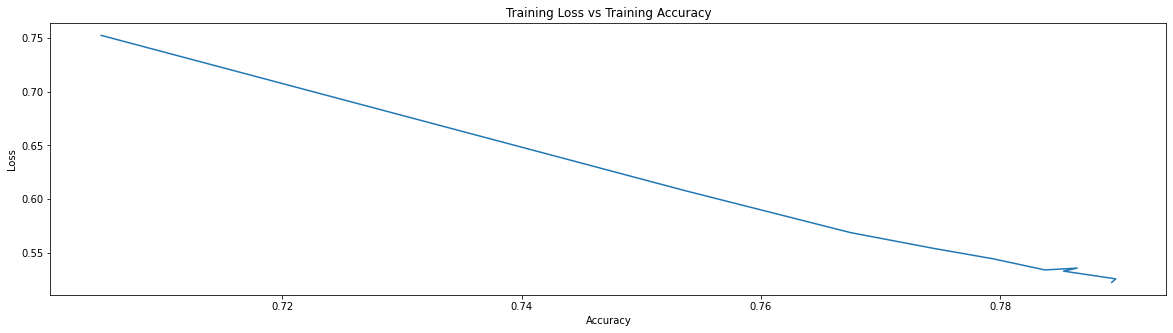

In [114]:
plt.plot(history_dense_model.history['accuracy'], history_dense_model.history['loss'])
plt.title("Training Loss vs Training Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

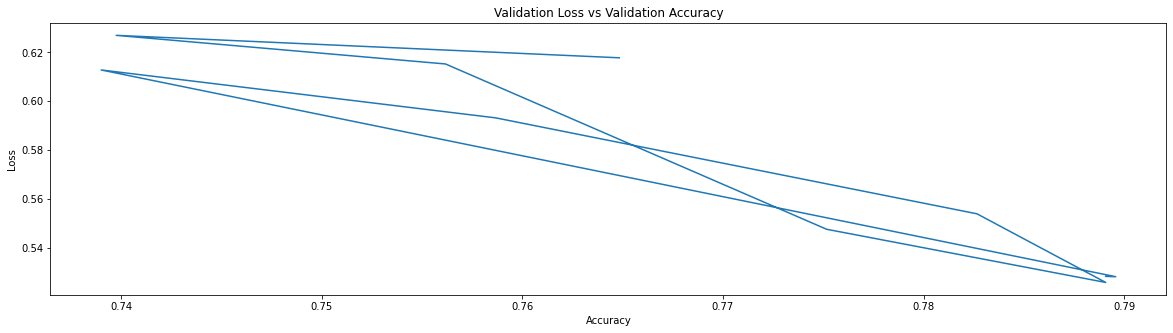

In [115]:
plt.plot(history_dense_model.history['val_accuracy'], history_dense_model.history['val_loss'])
plt.title("Validation Loss vs Validation Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Loss")

The training loss decreases smoothly against accuracy but the validation loss does not.

Testing on a random image

In [54]:
X_test[0].reshape(int(np.sqrt(pixel_count)), int(np.sqrt(pixel_count))).shape

(28, 28)

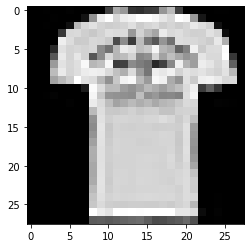

In [55]:
plt.imshow(X_test[0].reshape(int(np.sqrt(pixel_count)), int(np.sqrt(pixel_count))), cmap="gray")

In [56]:
X_test_flat[0].shape

(784,)

In [57]:
test = np.expand_dims(X_test_flat[0], axis=0)
test.shape

(1, 784)

In [58]:
dense_model.predict(test)

array([[6.8528615e-02, 8.9717156e-01, 3.3814643e-02, 1.2754760e-04,
        3.5769388e-04]], dtype=float32)

In [59]:
np.argmax(dense_model.predict(test))

1

In [60]:
y_test[0]

array([0., 1., 0., 0., 0.], dtype=float32)

# CM4

## Convolution Neural Networks

I now turn to CNNs.

Optimizer: Adam

Activation Functions: ReLU for internal and Softmax for output layer

Regularization Method: Early Stopping and Dropouts

Number of parameters: 110,309

Network Architecture: A convolution neural network with 32 and 64 kernels

> # Note:
The image shows 10 units in the softmax layer. However, 5 are implemented for this application.

![title](../images/cnn_basic.JPG)

Credits: https://www.linkedin.com/learning/neural-networks-and-convolutional-neural-networks-essential-training/

In [61]:
def calculate_image_dims(original_dim, filter_size, stride, padding):
    return ((original_dim - filter_size + 2*padding) / stride) + 1

In [62]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(36000, 28, 28, 1)
(36000, 5)
(12000, 28, 28, 1)
(12000, 5)
(12000, 28, 28, 1)
(12000, 5)


This time around, we don't have to and should not flatten the image since we will now be convolving kernels on the image matrix.

# CM 5 for CNN

## Implementation for CNN

In [63]:
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3,3), input_shape=X_train[0].shape, padding='same', activation='relu'))
# same means when stride is 1, pad zeros to keep same dimensions as opposed to using only 'valid' data
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(64,activation='relu'))
cnn.add(Dense(class_count,activation='softmax'))

# compile architecture
adam = optimizers.Adam(learning_rate=0.01)
cnn.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print(cnn.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                100416    
_________________________________________________________________
dense_13 (Dense)             (None, 5)                

In [64]:
# early stopping to avoid overfitting
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)
mc = ModelCheckpoint('../model/cnn/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# perform training
history_cnn = cnn.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[es, mc])

Epoch 1/10
1125/1125 [==============================] - 33s 3ms/step - loss: 0.6851 - accuracy: 0.7170 - val_loss: 0.4136 - val_accuracy: 0.8355

Epoch 00001: val_accuracy improved from -inf to 0.83550, saving model to model/cnn/best_model.h5
Epoch 2/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3938 - accuracy: 0.8442 - val_loss: 0.3612 - val_accuracy: 0.8605

Epoch 00002: val_accuracy improved from 0.83550 to 0.86050, saving model to model/cnn/best_model.h5
Epoch 3/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3469 - accuracy: 0.8614 - val_loss: 0.3570 - val_accuracy: 0.8635

Epoch 00003: val_accuracy improved from 0.86050 to 0.86350, saving model to model/cnn/best_model.h5
Epoch 4/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3358 - accuracy: 0.8652 - val_loss: 0.3660 - val_accuracy: 0.8519

Epoch 00004: val_accuracy did not improve from 0.86350
Epoch 5/10
1125/1125 [==============================] - 4s 3ms/step

In [65]:
# cnn.save('cnn_model/')
# cnn.save_weights('cnn_model_weights/')

In [66]:
# CM6 for CNN

## Results Analysis for CNN

In [67]:
# evaluate the model
train_loss, train_acc = cnn.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=0)

print("Accuracy:")
print('Train: %.3f, Valid: %.3f' % (train_acc, test_acc))
print("Loss:")
print('Train: %.3f, Valid: %.3f' % (train_loss, test_loss))

Accuracy:
Train: 0.901, Valid: 0.866
Loss:
Train: 0.247, Valid: 0.359


Text(0.5, 1.0, 'Training History')

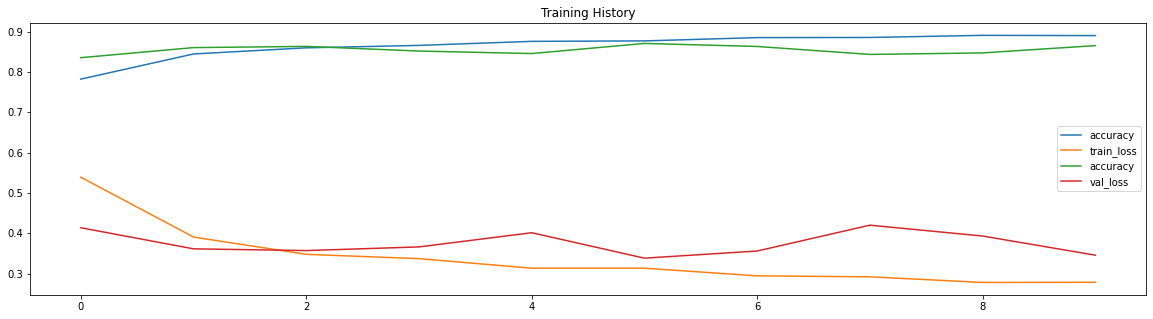

In [116]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_accuracy'])
plt.plot(history_cnn.history['val_loss'])
plt.legend(['accuracy', 'train_loss', 'accuracy', 'val_loss'])
plt.title("Training History")

Text(0, 0.5, 'Loss')

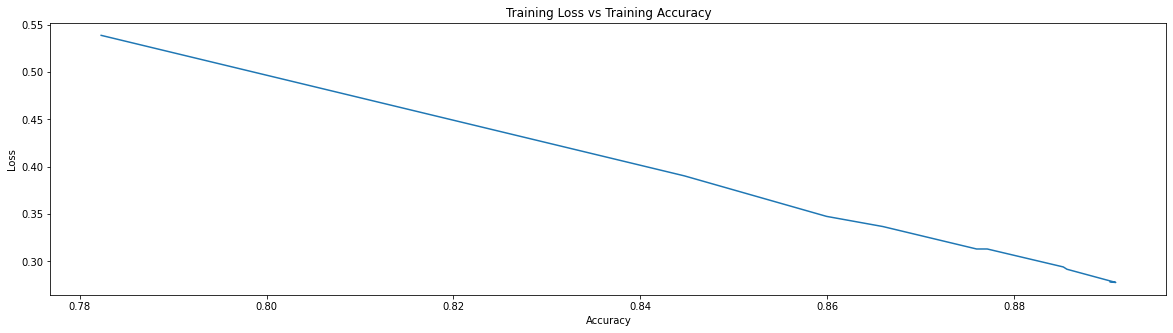

In [117]:
plt.plot(history_cnn.history['accuracy'], history_cnn.history['loss'])
plt.title("Training Loss vs Training Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

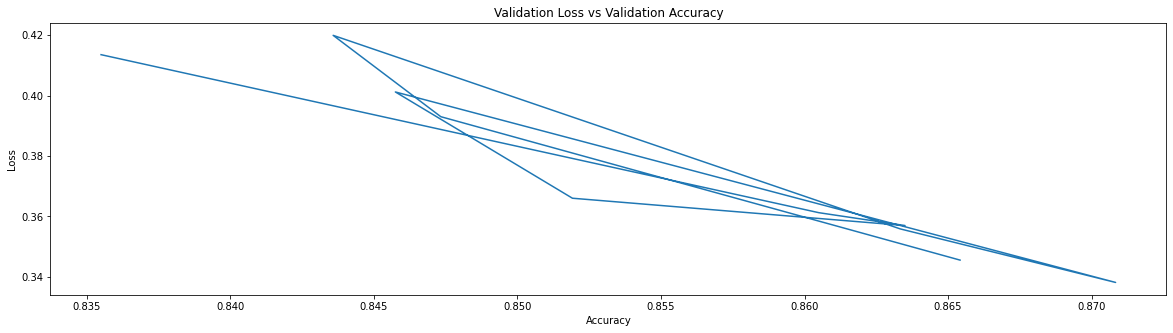

In [118]:
plt.plot(history_cnn.history['val_accuracy'], history_cnn.history['val_loss'])
plt.title("Validation Loss vs Validation Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Loss")

The training loss decreases smoothly against accuracy but the validation loss does not.

# CM4

## Resnet50

I now turn to the famous Resnet50 architecture that has proven to be very successful in computer vision applications.


Optimizer: Adam

Activation Functions: ReLU for internal and Softmax for output layer

Regularization Method: Dropout and Early Stopping

Number of parameters:

Trainable params: 23,528,320
Non-trainable params: 53,120

Network Architecture: Resnet50 with batch normalization, skip connection and average and max-pooling

![title](../images/resnet50.png)

Credits: https://github.com/priya-dwivedi/Deep-Learning/

# CM5 for Resnet50

## Implementation for ResNet50

In [71]:
X_train = X_train.reshape(-1, 28, 28)
X_valid = X_valid.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(36000, 28, 28)
(36000, 5)
(12000, 28, 28)
(12000, 5)
(12000, 28, 28)
(12000, 5)


In [72]:
def pad_numpy_images(images, padding=((2,2),(2,2))):
    padded_images = np.zeros((images.shape[0], images[0].shape[0] + (padding[0][0] + padding[0][1]),    
    images.shape[1] + (padding[1][0] + padding[1][1])))

    for i, image in enumerate(images):
        padded_images[i] = np.pad(image, padding, 'constant')
    
    return padded_images

X_train_padded = pad_numpy_images(X_train, padding=((2,2),(2,2)))
X_valid_padded = pad_numpy_images(X_valid, padding=((2,2),(2,2)))
X_test_padded = pad_numpy_images(X_test, padding=((2,2),(2,2)))

print(X_train_padded.shape)
print(y_train.shape)
print(X_valid_padded.shape)
print(y_valid.shape)
print(X_test_padded.shape)
print(y_test.shape)

(36000, 32, 32)
(36000, 5)
(12000, 32, 32)
(12000, 5)
(12000, 32, 32)
(12000, 5)


In [73]:
img_height, img_width, img_channels = 32, 32, 1
# if imagenet weights are being loaded, 
# input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width, img_channels))

In [74]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [75]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)

output_layer = Dense(class_count, activation= 'softmax')(x)
resnet50 = Model(inputs = base_model.input, outputs = output_layer)

adam = optimizers.Adam(learning_rate=0.01)
resnet50.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [77]:
# early stopping to avoid overfitting
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)
mc = ModelCheckpoint('../model/resnet50/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# perform training
history_resnet50 = resnet50.fit(X_train_padded, y_train,
                    epochs=10,
                    validation_data=(X_valid_padded, y_valid),
                    callbacks=[es, mc],
                    batch_size=64)

Epoch 1/10
563/563 [==============================] - 35s 52ms/step - loss: 3.5523 - accuracy: 0.4242 - val_loss: 10307.9961 - val_accuracy: 0.2051

Epoch 00001: val_accuracy improved from -inf to 0.20508, saving model to model/resnet50/best_model.h5
Epoch 2/10
563/563 [==============================] - 28s 50ms/step - loss: 2.9423 - accuracy: 0.5365 - val_loss: 435.4293 - val_accuracy: 0.2488

Epoch 00002: val_accuracy improved from 0.20508 to 0.24883, saving model to model/resnet50/best_model.h5
Epoch 3/10
563/563 [==============================] - 28s 50ms/step - loss: 2.9818 - accuracy: 0.6070 - val_loss: 2.7941 - val_accuracy: 0.6457

Epoch 00003: val_accuracy improved from 0.24883 to 0.64567, saving model to model/resnet50/best_model.h5
Epoch 4/10
563/563 [==============================] - 28s 49ms/step - loss: 1.8069 - accuracy: 0.6468 - val_loss: 2.8662 - val_accuracy: 0.5717

Epoch 00004: val_accuracy did not improve from 0.64567
Epoch 5/10
563/563 [===========================

# CM6 for Resnet50

## Results Analysis for Resnet50

In [78]:
# evaluate the model
train_loss, train_acc = resnet50.evaluate(X_train_padded, y_train, verbose=0)
test_loss, test_acc = resnet50.evaluate(X_test_padded, y_test, verbose=0)

print("Accuracy:")
print('Train: %.3f, Valid: %.3f' % (train_acc, test_acc))
print("Loss:")
print('Train: %.3f, Valid: %.3f' % (train_loss, test_loss))

Accuracy:
Train: 0.400, Valid: 0.404
Loss:
Train: 4.156, Valid: 4.245


Text(0.5, 1.0, 'Training History')

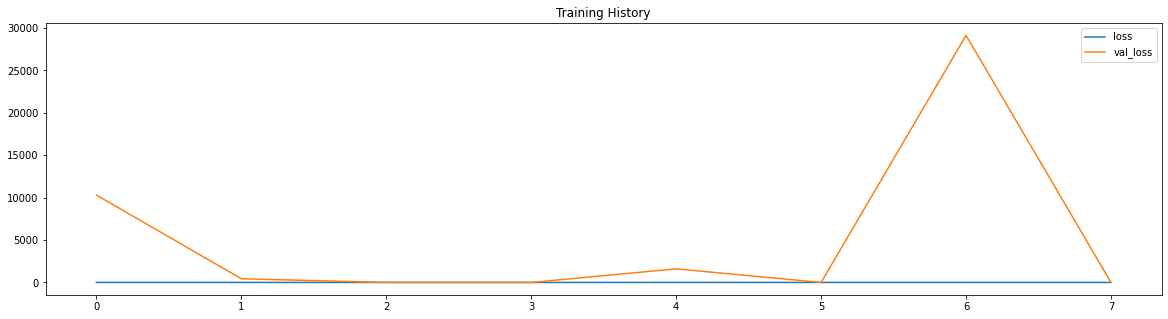

In [123]:
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title("Training History")

Text(0.5, 1.0, 'Training History')

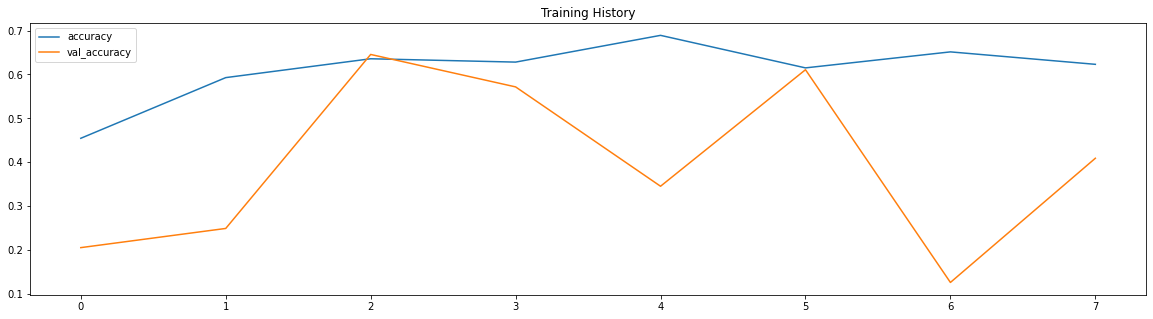

In [125]:
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title("Training History")

Text(0.5, 1.0, 'Validation Loss vs Validation Accuracy')

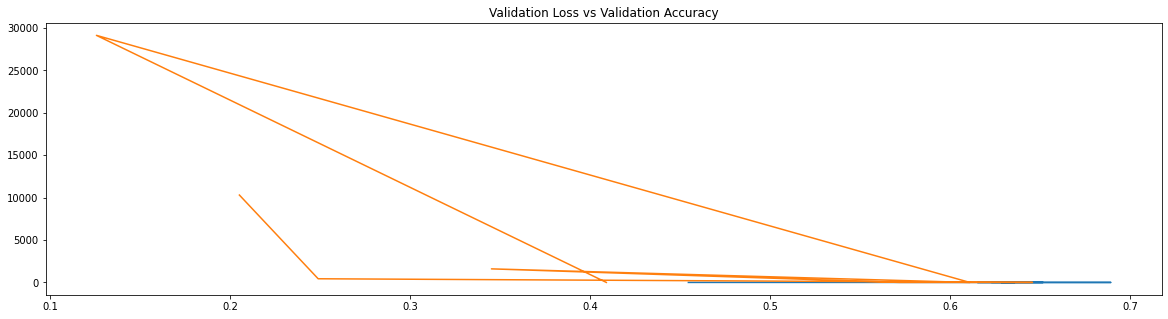

In [120]:
plt.plot(history_resnet50.history['accuracy'], history_resnet50.history['loss'])
plt.title("Training Loss vs Training Accuracy")

plt.plot(history_resnet50.history['val_accuracy'], history_resnet50.history['val_loss'])
plt.title("Validation Loss vs Validation Accuracy")

## Comparative Analysis

Fully-Connected Neural Network vs CNN vs ResNet50

Text(0.5, 1.0, 'Comparative Analysis of Training and Validation Performance of FCN, CNN and ResNet50')

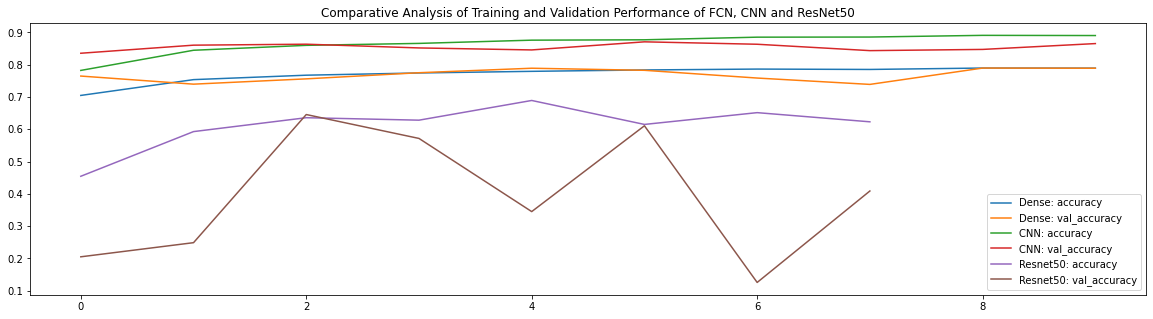

In [121]:
plt.plot(history_dense_model.history['accuracy'])
plt.plot(history_dense_model.history['val_accuracy'])
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.legend(['Dense: accuracy', 'Dense: val_accuracy', 'CNN: accuracy', 'CNN: val_accuracy', 'Resnet50: accuracy', 'Resnet50: val_accuracy'])
plt.title("Comparative Analysis of Training and Validation Performance of FCN, CNN and ResNet50")

1. FCN: Adam works better mostly. Also, adding dropouts decreased the performance considerably.
2. CCN: As was expected, CNNs in general perform way better than simple FCNs in such tasks.
3. ResNet50: It it too slow to train and very computationally expensive. Due to limited time and computing resources, I only kept the epochs to 10 but they can be increased to test how the model performs.

# Kaggle Predictions

In [96]:
kaggle_data = np.load(r'.data/fashion_mnist_dataset_kaggle_test.npy', allow_pickle=True).item()

In [97]:
kaggle_data['features'].shape

(10000, 28, 28)

In [98]:
pixel_count = kaggle_data['features'][0].shape[0] * kaggle_data['features'][0].shape[1]
pixel_count

784

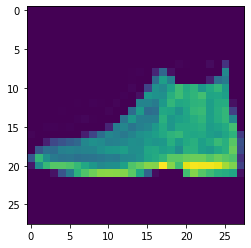

In [99]:
plt.imshow(kaggle_data['features'][0])

In [100]:
test_flat = flatten_image_set(kaggle_data['features'], pixel_count)
test_flat.shape

(10000, 784)

In [101]:
test = np.expand_dims(kaggle_data['features'], axis=0).reshape(-1, 28, 28, 1)
test.shape

(10000, 28, 28, 1)

In [102]:
test_padded = pad_numpy_images(kaggle_data['features'], padding=((2,2),(2,2))).reshape(-1, 32, 32, 1)
test_padded.shape

(10000, 32, 32, 1)

In [103]:
dense_model_preds = np.argmax(dense_model.predict(test_flat), axis=1) + 1
cnn_preds = np.argmax(cnn.predict(test), axis=1) + 1
resnet50_preds = np.argmax(resnet50.predict(test_padded), axis=1) + 1

print("Dense: ", dense_model_preds)
print("CNN: ", cnn_preds)
print("Resnet50: ", cnn_preds)

Dense:  [4 3 2 ... 4 2 4]
CNN:  [4 3 2 ... 4 2 4]
Resnet50:  [4 3 2 ... 4 2 4]


In [104]:
df = pd.DataFrame({ "target" : dense_model_preds,
            }).reset_index().rename(columns={"index":"Id"})

df.to_csv("output/dense_kaggle_predictions.csv", index=False)

In [105]:
df = pd.DataFrame({ "target" : cnn_preds,
            }).reset_index().rename(columns={"index":"Id"})

df.to_csv("output/cnn_kaggle_predictions.csv", index=False)

In [106]:
df = pd.DataFrame({ "target" : resnet50_preds,
            }).reset_index().rename(columns={"index":"Id"})

df.to_csv("output/resnet50_kaggle_predictions.csv", index=False)

In [107]:
# !zip -r log.zip ./model/

updating: model/ (stored 0%)
updating: model/cnn/ (stored 0%)
updating: model/cnn/best_model.h5 (deflated 35%)
updating: model/resnet50/ (stored 0%)
updating: model/resnet50/best_model.h5 (deflated 24%)
updating: model/dense_model/ (stored 0%)
updating: model/dense_model/best_model.h5 (deflated 39%)


In [108]:
# files.download('log.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>